## Curso: Proyecto Integrador
### Integrantes:

#### Andrea Carolina Garza Nacif A01280427
#### Jhamyr Arnulfo Alcalde Oballe A01795409
#### Víctor Arista Beltrán A01012223

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
from pathlib import Path
from IPython.display import Markdown, display
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    VotingClassifier,
    StackingClassifier
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (
    roc_auc_score, precision_score, RocCurveDisplay,
    confusion_matrix, ConfusionMatrixDisplay,
    average_precision_score, PrecisionRecallDisplay,classification_report
)
from sklearn.model_selection import (
    train_test_split, cross_val_score, RepeatedStratifiedKFold,
    RandomizedSearchCV
)
import joblib, time, pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from scipy.stats import randint, uniform

sns.set(style="whitegrid")
import warnings
warnings.filterwarnings("ignore")

In [28]:
#CARGA Y LIMPIEZA BÁSICA

DATA_PATH = Path("/content/drive/MyDrive/Colab Notebooks/Proyecto Integrador/PROYECTO AVANCE/avance4/sparkvista_dataset.csv")
df = pd.read_csv(DATA_PATH)


# Fechas → año
for col in ["Year Founded", "IPO Date"]:
    df[col] = (df[col].astype(str).str.extract(r'(\d{4})')[0]
               .astype("Int64"))
    df[col] = pd.to_datetime(df[col], format='%Y', errors='coerce')

# Variable numérica derivada
df["Company_Age"] = 2025 - df["Year Founded"].dt.year

In [ ]:
#DEFINICIÓN TARGET BINARIO
fund_q75 = df["Total Funding Amount (USD)"].quantile(0.75)
df["HighPotential"] = (
        (df["Total Funding Amount (USD)"] >= fund_q75) |
        (df["Funding Status"].str.contains("IPO|Public|Acquired", na=False))
).astype(int)

y = df["HighPotential"].values
X = df.drop(columns=["HighPotential", "Total Funding Amount (USD)"])

print("X shape:", X.shape, "| Positivos:", y.sum())

X shape: (1010, 26) | Positivos: 196


In [ ]:
#PRE-PIPELINE
num_cols = X.select_dtypes(include='number').columns.tolist()
cat_cols = X.select_dtypes(include='object').columns.tolist()

numeric_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("sc",  StandardScaler())
])

# Ajuste parámetro sparse / sparse_output según versión
from packaging import version
from sklearn import __version__ as skl_ver
if version.parse(skl_ver) >= version.parse("1.2"):
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
else:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

categorical_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("ohe", ohe)
])

prep = ColumnTransformer([
    ("num", numeric_pipe, num_cols),
    ("cat", categorical_pipe, cat_cols)
])


In [ ]:
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)


In [ ]:
base_models = {
    "Logistic": LogisticRegression(max_iter=1000, C=1.0, n_jobs=-1),
    "DecisionTree": DecisionTreeClassifier(max_depth=None, random_state=42),
    "SVC": SVC(kernel="rbf", probability=True, random_state=42),
    "GradBoost": GradientBoostingClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42)
}

In [ ]:
voting_clf = VotingClassifier(
    estimators=[
        ("log", base_models["Logistic"]),
        ("svc", base_models["SVC"]),
        ("gb",  base_models["GradBoost"])
    ],
    voting="soft", n_jobs=-1
)

stack_clf = StackingClassifier(
    estimators=[
        ("log", base_models["Logistic"]),
        ("svc", base_models["SVC"]),
        ("gb",  base_models["GradBoost"])
    ],
    final_estimator=LogisticRegression(max_iter=1000),
    cv=5, n_jobs=-1
)

In [ ]:
search_spaces = {
    "RandomForest": { "clf__n_estimators": [200,400,600],
                      "clf__max_depth": [None,10,20],
                      "clf__max_features": ["sqrt","log2"] },
    "GradBoost":    { "clf__n_estimators": [100,200,400],
                      "clf__learning_rate": [0.01,0.05,0.1],
                      "clf__max_depth": [2,3,4] },
    "Voting":       { "clf__weights": [(1,1,1), (2,1,2), (1,2,1)] }
    # Stacking no suele afinarse; usa CV interno.
}

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)
models_to_fit = {**base_models, "Voting": voting_clf, "Stacking": stack_clf}

results = []
fitted = {}

for name, model in models_to_fit.items():
    pipe = Pipeline([("prep", prep), ("clf", model)])

    # Ajuste fino si corresponde
    if name in search_spaces:
        rs = RandomizedSearchCV(
            pipe,
            param_distributions=search_spaces[name],
            n_iter=20, scoring="roc_auc",
            cv=cv, n_jobs=-1, random_state=42
        )
        start = time.time();  rs.fit(X_tr, y_tr);  dur = time.time() - start
        pipe = rs.best_estimator_
        best_params = rs.best_params_
    else:
        start = time.time();  pipe.fit(X_tr, y_tr);  dur = time.time() - start
        best_params = {}

    fitted[name] = pipe

    # Métricas en test
    proba = pipe.predict_proba(X_te)[:,1] if hasattr(pipe,"predict_proba") \
           else pipe.decision_function(X_te)
    auc = roc_auc_score(y_te, proba)
    top20 = proba.argsort()[::-1][:20]
    prec20 = precision_score(y_te[top20], np.ones(20))

    results.append({
        "Model": name,
        "AUC": auc,
        "Precision@20": prec20,
        "Train time (s)": dur,
        "Params": best_params
    })

In [ ]:
df_cmp = pd.DataFrame(results).sort_values("AUC", ascending=False)
display(df_cmp[["Model","AUC","Precision@20","Train time (s)"]])

,Model,AUC,Precision@20,Train time (s)
7,Stacking,0.858188,0.85,95.025261
4,RandomForest,0.857480,0.80,383.557950
6,Voting,0.857401,0.85,392.587107
3,GradBoost,0.854098,0.90,2919.699465
2,SVC,0.850480,0.85,10.251146
0,Logistic,0.845761,0.75,3.402143
5,AdaBoost,0.822872,0.85,2.612362
1,DecisionTree,0.689791,0.75,0.273069


In [ ]:
final_name = df_cmp.iloc[0]["Model"]
final_model = fitted[final_name]
print(">>> Modelo final elegido:", final_name)
joblib.dump(final_model, "/content/drive/MyDrive/model_final.pkl")

>>> Modelo final elegido: Stacking


['/content/drive/MyDrive/model_final.pkl']

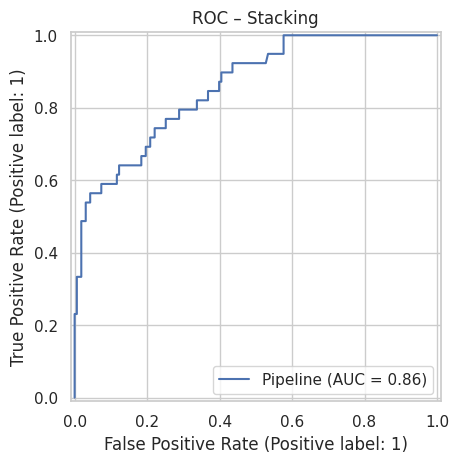

In [ ]:
# 1. ROC
RocCurveDisplay.from_estimator(final_model, X_te, y_te)
plt.title(f"ROC – {final_name}"); plt.show()

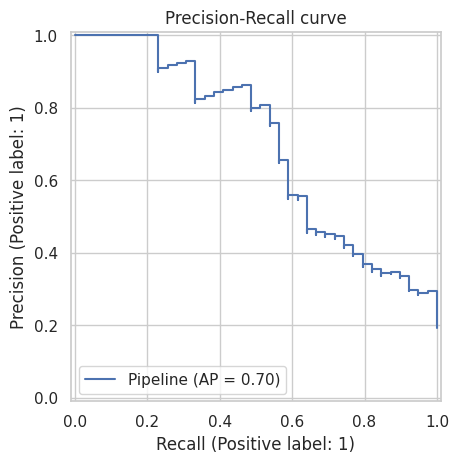

In [ ]:
# 2. Curva Precisión-Recall
PrecisionRecallDisplay.from_estimator(final_model, X_te, y_te)
plt.title("Precision-Recall curve"); plt.show()

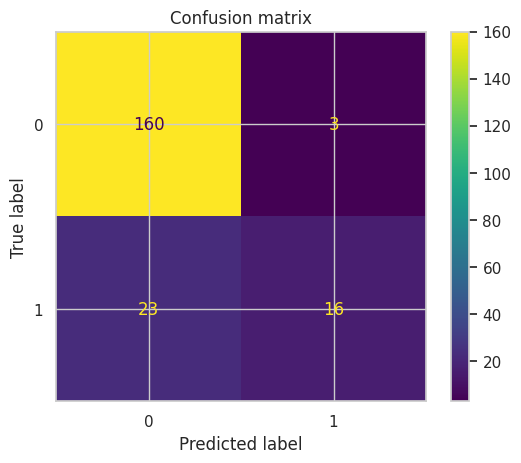

In [ ]:
# 3. Matriz de confusión (umbral 0.5)
y_pred = final_model.predict(X_te)
ConfusionMatrixDisplay.from_predictions(y_te, y_pred)
plt.title("Confusion matrix"); plt.show()

In [27]:
# 4. Importancia de características (si el modelo la expone)
if hasattr(final_model.named_steps["clf"], "feature_importances_"):
    importances = final_model.named_steps["clf"].feature_importances_
    names = final_model.named_steps["prep"].get_feature_names_out()
    idx = np.argsort(importances)[-15:]
    plt.barh(range(15), importances[idx]); plt.yticks(range(15), names[idx])
    plt.title("Top-15 feature importances"); plt.xlabel("Gini importance")
    plt.show()

Después de realizar las pruebas con múltiples modelos individuales y de ensamble, hemos seleccionado **Stacking** como nuestro modelo final, este logró el mejor desempeño en general. Obtuvo un **AUC-ROC de 0.86**, lo que significa que puede distinguir correctamente entre startups de alto y bajo potencial en el 86 % de los casos. Además, mantiene una **precisión del 85 % en el Top-20 de recomendaciones**, lo cual es clave para el negocio, ya que reduce significativamente el trabajo de revisión sin sacrificar los aciertos.

Durante el proceso también hemos analizado el comportamiento de los modelos como SVC y Gradient Boosting. Si bien GradBoost obtuvo la mayor precisión puntual (90 %), su tiempo de entrenamiento fue 30 veces mayor que el de Stacking, sin ofrecer una mejora sustancial en AUC. Por otro lado, SVC fue más rápido, pero se quedó ligeramente por debajo en ambas métricas. Esto ayudó a seleccionar finalmente al modelo Stacking teniendo en cuenta el equilibrio óptimo entre rendimiento, precisión y eficiencia.

Hemos visto también que el modelo es bastante conservador es decir comete muy pocos falsos positivos, aunque deja pasar algunos casos buenos. Esto es una gran ventaja si se prioriza calidad sobre cantidad. La curva precisión recall nos muestra que podemos ajustar ese equilibrio si el punto de priorización cambia por ejemplo a cobertura.

Se tiene considerado proponer los siguientes pasos:

* Afinar el umbral de decisión según la tolerancia al riesgo del inversionista.
* Explorar técnicas para mejorar el **recall** sin comprometer demasiado la precisión (por ejemplo, ajustar pesos o usar SMOTE).
* Automatizar la re entrenación del modelo conforme se incorporen nuevas start ups.

Finalmente podemos decir que tenemos un modelo robusto, confiable y accionable para priorizar inversiones de forma más inteligente y eficiente.
